<a href="https://colab.research.google.com/github/sumerberksener/Detect-Pneumonia-Using-X-Ray-Images-with-CNNs-and-Transfer-Learning/blob/main/Detect_Pneumonia_Using_X_Ray_Images_with_CNNs_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning


## Introduction
In this project I will put my deep learning skills to use by trying to train a convolutional neural netwrok to identify the risk cases of pneumonia by looking at an X-ray image.

According to the [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1), pneumonia killed more than 808,000 children under the age of five in 2017. An accurate and timely diagnosis of the disease could be the difference in saving many lives.

Thanks to researchers from the University of California, San Diego, we have access to a [dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2) containing 5856 chest X-ray images from children, split between a training dataset and a test dataset. Each image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it.



Download the file into the colab session using the following link.

In [34]:
# load the file
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

--2023-12-16 09:46:29--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.105.196, 54.231.202.17, 52.217.224.65, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.105.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz.2’

xray_dataset.tar.gz 100%[===================>]   1.14G  33.2MB/s    in 36s     

2023-12-16 09:47:06 (32.3 MB/s) - ‘xray_dataset.tar.gz.2’ saved [1223407715/1223407715]



Use the `extract_tar_gz()` function to extract the dataset.

In [35]:
# extract the dataset
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

# Use it like this:
extract_tar_gz('xray_dataset.tar.gz', '.')

Import the required libraries in the next cell and load in the training, validation and test datasets. I will use a `batch_size` of 128 and and `image_size` of 256*256 to avoid running into Out Of Memory error.

I will use 20% of my training set as the validation set. Set the random seed to 417 for reproducibility.

In [36]:
# import the required libraries and create train, test, validation sets
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling

train_set = image_dataset_from_directory(directory = 'chest_xray/train',
                                         labels = 'inferred',
                                         label_mode = 'categorical',
                                         batch_size = 128,
                                         image_size = (256,256),
                                         validation_split = 0.20,
                                         subset = 'training',
                                         seed = 417)

validation_set = image_dataset_from_directory(directory = 'chest_xray/train',
                                         labels = 'inferred',
                                         label_mode = 'categorical',
                                         batch_size = 128,
                                         image_size = (256,256),
                                         validation_split = 0.20,
                                         subset = 'validation',
                                         seed = 417)

test_set = image_dataset_from_directory(directory = 'chest_xray/test',
                                         labels = 'inferred',
                                         label_mode = 'categorical',
                                         batch_size = 128,
                                         image_size = (256,256))


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


Next, I will rescale the dataset I imported. The rescaling factor is 1/255 gecause the images have size (256, 256, 3), hence the pixel values range between 0-255. Diving by 255 allows us to rescale all values to the range [0,1].

In [37]:
# rescale the datasets
normalization_layer = Rescaling(scale = 1/255)
train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))


## Data Exploration
Now explore the dataset we have by displaying some of the images and their associated labels. Start by printing out the class names.

In [38]:
# display class names of the training data
train_set.class_names

['NORMAL', 'PNEUMONIA']

As seen above, there are two classes in the dataset: `NORMAL` and `PNEUMONIA`.
<br>
I will convert tensorflow datasets to `numpy` arrays.

In [39]:
# convert the images and labels in the first batch to numpy arrays
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
  images = images.numpy()
  labels = labels.numpy()


Now display different images from the first batch of the training set. Choose five images to display. Print out the labels for those images.

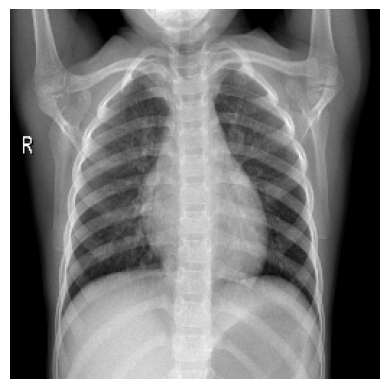

Training set image label : [1. 0.]
Training set image label shape : (256, 256, 3)


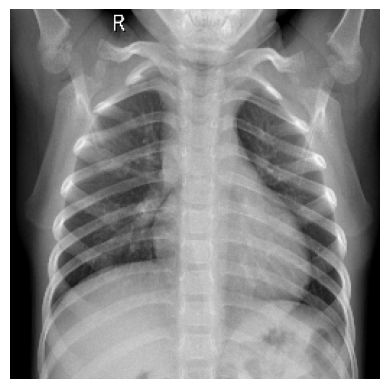

Training set image label : [1. 0.]
Training set image label shape : (256, 256, 3)


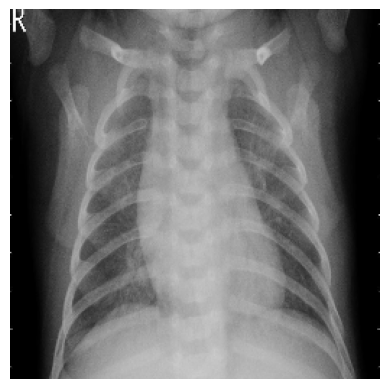

Training set image label : [0. 1.]
Training set image label shape : (256, 256, 3)


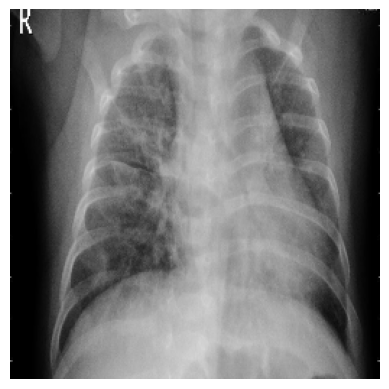

Training set image label : [0. 1.]
Training set image label shape : (256, 256, 3)


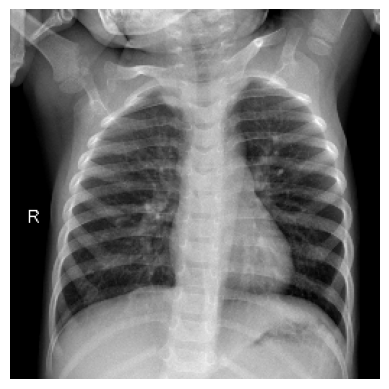

Training set image label : [1. 0.]
Training set image label shape : (256, 256, 3)


In [40]:
# display the training images
import numpy as np
import matplotlib.pyplot as plt

selected_indices = np.linspace(1, 127, 5).astype(int)

for i, index in enumerate(selected_indices, 1):
    image = images[i]/255.0
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    print(f'Training set image label : {labels[i]}')
    print(f'Training set image label shape : {images[i].shape}')



In the next cell display five random images from the test set. Print out the labels for those images.

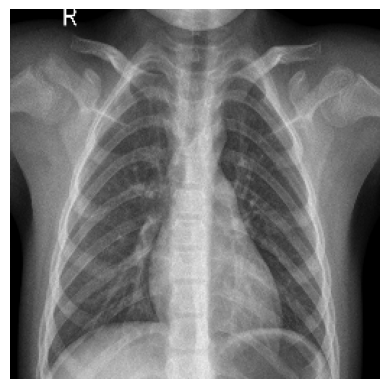

Training set image label : [1. 0.]
Training set image label shape : (256, 256, 3)


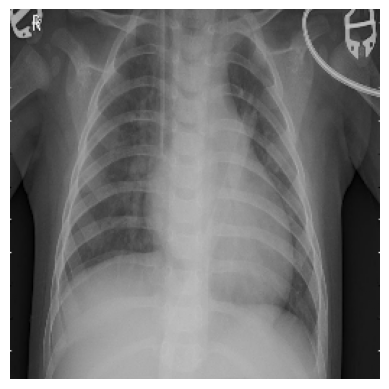

Training set image label : [0. 1.]
Training set image label shape : (256, 256, 3)


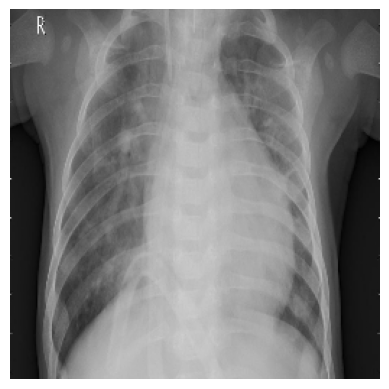

Training set image label : [0. 1.]
Training set image label shape : (256, 256, 3)


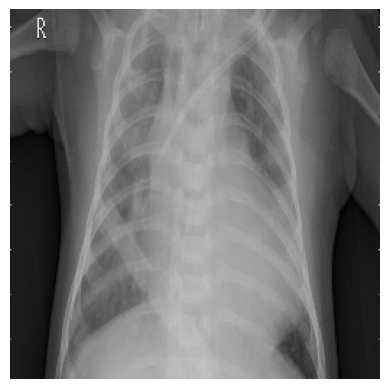

Training set image label : [0. 1.]
Training set image label shape : (256, 256, 3)


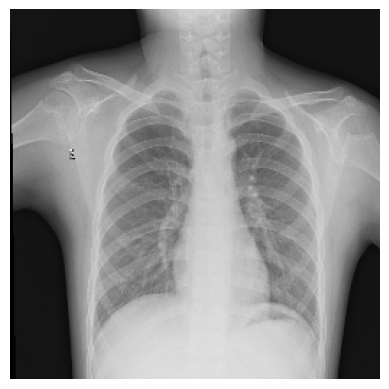

Training set image label : [1. 0.]
Training set image label shape : (256, 256, 3)


In [41]:
# display the tet images
for images, labels in test_set:
  images = images.numpy()
  labels = labels.numpy()

selected_indices = np.linspace(1, 127, 5).astype(int)

for i, index in enumerate(selected_indices, 1):
    image = images[i]/255.0
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    print(f'Training set image label : {labels[i]}')
    print(f'Training set image label shape : {images[i].shape}')


Because our training set has only 5856 images in total, and we're using 20% of this as our validation set, the model we are going to develop could benefit from data augmentation. I am considering using `RandomRotation` and `RandomZoom` as the main methods of augmenting the data.

##  First Model: Simple CNN I
In this section I will be developing a simple CNN model. The main objective of this model is to act as a starting model. Later models in this project will include tuning hyperparameters and employing more advanced techniques like transfer learning.

In [42]:
# instantiate the model
from tensorflow.keras import Sequential

cnn_simple  = Sequential()

Having created an instance of the Sequential API, I will now add the layers to my model. I will add the following layers in the order they appear:
1. one convolutional layer
2. one max pooling layer
3. one flatten layer
4. one fully connected layer
5. an output layer with the number of units equal to the number of classes in our data, which is 2.


In [43]:
# import and add the layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input

cnn_simple.add(Input(shape = (256, 256,3)))
cnn_simple.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     strides = 2,
                     activation = 'relu'
                     ))
cnn_simple.add(MaxPooling2D(pool_size = 3,
                           strides = 2))
cnn_simple.add(Flatten())
cnn_simple.add(Dense(16,
                    activation = 'relu'))
cnn_simple.add(Dense(2))

cnn_simple.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 63504)             0         
                                                                 
 dense_16 (Dense)            (None, 16)                1016080   
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1016562 (3.88 MB)
Trainable params: 1016562 (3.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Next, instantiate and `Adam()` optimizer with `learning_rate` equal to `0.01`. Use `CategoricalCrossentropy` as our loss function when compiling the model. Fit the model on `train_set_normalized` and use `validation_set_normalized` as the `validation_data` when fitting the model. Train the model for 5 epochs and evaluate it on `test_set_normalized`.

In [44]:
# compile and evaluate the model
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate = 0.01)
loss = CategoricalCrossentropy(from_logits = True)
cnn_simple.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])
cnn_simple.fit(train_set_normalized, epochs = 5, validation_data = validation_set_normalized)
test_loss, test_acc = cnn_simple.evaluate(test_set_normalized)
test_acc

Epoch 1/5
33/33 [==============================] - 43s 1s/step - loss: 3.5403 - accuracy: 0.7456 - val_loss: 0.3191 - val_accuracy: 0.8728
Epoch 2/5
33/33 [==============================] - 41s 1s/step - loss: 0.3222 - accuracy: 0.9233 - val_loss: 0.1991 - val_accuracy: 0.9111
Epoch 3/5
33/33 [==============================] - 37s 951ms/step - loss: 0.1206 - accuracy: 0.9539 - val_loss: 0.1279 - val_accuracy: 0.9532
Epoch 4/5
33/33 [==============================] - 40s 1s/step - loss: 0.0639 - accuracy: 0.9756 - val_loss: 0.1102 - val_accuracy: 0.9551
Epoch 5/5
5/5 [==============================] - 3s 46ms/step - loss: 1.0015 - accuracy: 0.7788


0.7788461446762085

Our model performed briliantly on the training and validation datasets. An accuracy score of 0.78 looks really good given that the model is quite simple and we haven't applied any optimisation techniques yet. However, the test accuracy was quite far behind both of those values. This suggests that our model is overfitting.

## First Model: Simple CNN II
In this section I will use some techniques to improve the performance of the previous model.

Add `Dropout` layers to tackle the overfitting problem. Moreover, introduce `RandomZoom` and `RandomRotation` layers to augment the data. Add another convolutional layer and increase the number of the fully connected layers to improve the model.

In [45]:
from tensorflow.keras.layers import RandomZoom, RandomRotation, Dropout
img_size = 256

cnn_simple_2 = Sequential()

cnn_simple_2.add(RandomZoom(height_factor=0.1))
cnn_simple_2.add(RandomRotation(factor=0.2))

cnn_simple_2.add(Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
cnn_simple_2.add(MaxPooling2D(pool_size=3, strides=2))

cnn_simple_2.add(Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
cnn_simple_2.add(MaxPooling2D(pool_size=3, strides=2))
cnn_simple_2.add(Flatten())

cnn_simple_2.add(Dense(256, activation='relu'))
cnn_simple_2.add(Dropout(0.5))

cnn_simple_2.add(Dense(64, activation='relu'))
cnn_simple_2.add(Dropout(0.5))

cnn_simple_2.add(Dense(32, activation='relu'))
cnn_simple_2.add(Dropout(0.5))

cnn_simple_2.add(Dense(2))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cnn_simple_2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
cnn_simple_2.build((None, img_size, img_size, 3))

cnn_simple_2.summary()
cnn_simple_2.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_3 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_7 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 256)      

In [46]:
# evaluate first model
test_loss, test_acc = cnn_simple_2.evaluate(test_set_normalized)
test_acc

5/5 [==============================] - 4s 88ms/step - loss: 0.4513 - accuracy: 0.8221


0.8221153616905212

Our improved simple CNN model is performing better than the previous one. The model has achieved an accuracy score of 0.82 on the test set. Moreover, comparing the `accuracy` and `val_accuracy` values, we can see that we have solved the overfitting problem for the most part. This was achieved by implementing the regularization techniques such as `Dropout` layers and data augmentation.

## Second Model: Transfer Learning

Having trained a CNN model from ground up ourselves, in the remaining parts of this project we'll make use of a powerful pre-trained model called `ResNet50V2`. Use transfer learning to see how this model performs on the `chest_xray` dataset.

In [47]:
# instantiate the transfer learning model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, ReLU, RandomFlip
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3))

base_model.trainable = False

input_layer = Input(shape = (256, 256, 3))

preprocessed_input_layer = preprocess_input(input_layer)
augmentation_layer = RandomFlip('horizontal')(preprocessed_input_layer)
augmentation_layer = RandomRotation(0.2)(augmentation_layer)
augmentation_layer = RandomZoom(height_factor = 0.1)(augmentation_layer)

features_layer = base_model(augmentation_layer, training=False)
global_pooling = GlobalAveragePooling2D()(features_layer)

dense_1 = Dense(512)(global_pooling)
dropout_1 = Dropout(0.50)(dense_1)
relu_1 = ReLU()(dropout_1)


dense_2 = Dense(128)(relu_1)
dropout_2 = Dropout(0.5)(dense_2)
relu_2 = ReLU()(dropout_2)

dense_3 = Dense(32)(relu_2)
dropout_3 = Dropout(0.5)(dense_3)
relu_3 = ReLU()(dropout_3)

output = Dense(2)(relu_3)

cnn_transfer = Model(inputs = input_layer, outputs = output)

callback = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, restore_best_weights = True)

opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
cnn_transfer.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

history = cnn_transfer.fit(train_set, epochs = 10, validation_data = validation_set)


Epoch 1/10
33/33 [==============================] - 47s 1s/step - loss: 1.1985 - accuracy: 0.6873 - val_loss: 0.5429 - val_accuracy: 0.7629
Epoch 2/10
33/33 [==============================] - 40s 1s/step - loss: 0.4871 - accuracy: 0.7422 - val_loss: 0.3195 - val_accuracy: 0.7629
Epoch 3/10
33/33 [==============================] - 39s 1s/step - loss: 0.2883 - accuracy: 0.8588 - val_loss: 0.1820 - val_accuracy: 0.9264
Epoch 4/10
33/33 [==============================] - 40s 1s/step - loss: 0.2418 - accuracy: 0.9200 - val_loss: 0.1605 - val_accuracy: 0.9407
Epoch 5/10
33/33 [==============================] - 39s 1s/step - loss: 0.2151 - accuracy: 0.9219 - val_loss: 0.1707 - val_accuracy: 0.9522
Epoch 6/10
33/33 [==============================] - 39s 1s/step - loss: 0.2244 - accuracy: 0.9236 - val_loss: 0.1555 - val_accuracy: 0.9273
Epoch 7/10
33/33 [==============================] - 41s 1s/step - loss: 0.1862 - accuracy: 0.9381 - val_loss: 0.1726 - val_accuracy: 0.9293
Epoch 8/10
33/33 [==

Having trained our model, now is the time to test it on the test set.

In [48]:
test_loss, test_acc = cnn_transfer.evaluate(test_set)
test_acc

5/5 [==============================] - 4s 170ms/step - loss: 0.3400 - accuracy: 0.8830


0.8830128312110901

Clearly, this model is performing much better than both of the previous models. It achieved an accuracy score of 0.88 and the overfitting problems is close to being non-existent.

Having trained the model, plot the accuracies and losses against each other.

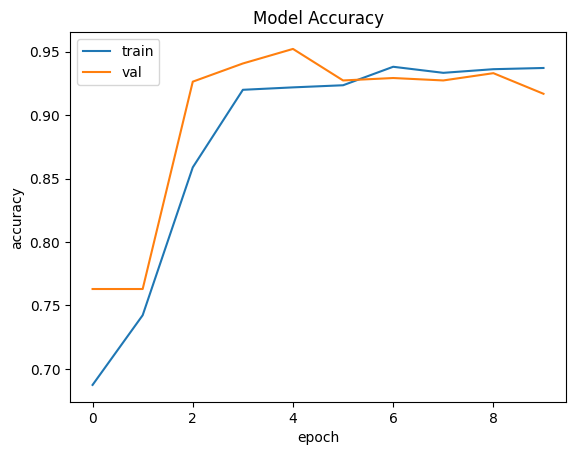

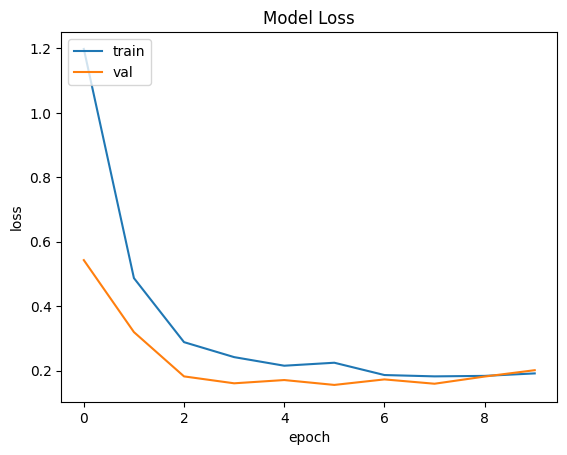

In [49]:
# plot the accuracies and losses
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Both graphs plateaued after roughly 8 epochs. This is a good sign meaning that 10 epochs was an enough number of epochs to train for. If it were the case that the graphs were still going down or doing up after 10 epochs, we would need to train the model for a longer period of time.

It is clear that the `accuracy` and `val_accuracy` have increased quite a bit over the training period. The opposite is true for the `loss` and `val_loss`.

Note that the difference between `val_loss` and `loss` is extremely small after 10 epochs. The same could be said about `accuracy` and `val_accuracy`. This confirms graphically that we have solved the overfitting problem.

Next, try improving the transfer learning model by using a lower `learning_rate` and allowing the last 10 layers in the model to be trained. Train for 5 epochs.

In [50]:
# improve the transfer learning model
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

cnn_transfer_2 = Model(inputs = input_layer, outputs = output)

opt = Adam(learning_rate = 0.0001)
loss = CategoricalCrossentropy(from_logits= True)
cnn_transfer_2.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

callback = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
cnn_transfer_2.fit(train_set, epochs = 5, validation_data = validation_set, callbacks = [callback])




Epoch 1/5
33/33 [==============================] - 47s 1s/step - loss: 0.1655 - accuracy: 0.9434 - val_loss: 0.2016 - val_accuracy: 0.8987
Epoch 2/5
33/33 [==============================] - 42s 1s/step - loss: 0.1439 - accuracy: 0.9494 - val_loss: 0.2097 - val_accuracy: 0.9369
Epoch 3/5
33/33 [==============================] - 40s 1s/step - loss: 0.1473 - accuracy: 0.9477 - val_loss: 0.1185 - val_accuracy: 0.9465
Epoch 4/5
33/33 [==============================] - 40s 1s/step - loss: 0.1235 - accuracy: 0.9599 - val_loss: 0.2056 - val_accuracy: 0.9120
Epoch 5/5
33/33 [==============================] - 41s 1s/step - loss: 0.1126 - accuracy: 0.9599 - val_loss: 0.1682 - val_accuracy: 0.9273


Having trained the second transfer learning CNN model, evaluate it on the test set to see how it performs.

In [51]:
test_loss, test_acc = cnn_transfer_2.evaluate(test_set)
test_acc

5/5 [==============================] - 4s 170ms/step - loss: 0.4088 - accuracy: 0.8878


0.8878205418586731

Although marginal, the accuracy score has gone up in the second version of the transfer learning model. Note that the second model was only trained for 5 epochs rather than 10 like the first one. Hence, we can safely assumet that the second transfer learning model is a better model than the first one, achieving an accuracy score of 0.89 on the test data.

## Evaluating on the Test Set
In this section, compare the two different models used by comparing the test scores they achieved on the test set.

In [52]:
# print the test accuracy for the improved version of both of the models
test_loss, test_acc = cnn_simple_2.evaluate(test_set_normalized)
print(f'The test accuracy for the improved simple CNN model : {test_acc}')


test_loss, test_acc = cnn_transfer_2.evaluate(test_set)
print(f'The test accuracy for the improved trasfer learning model : {test_acc}')



5/5 [==============================] - 5s 105ms/step - loss: 0.4513 - accuracy: 0.8221
The test accuracy for the improved simple CNN model : 0.8221153616905212
5/5 [==============================] - 4s 168ms/step - loss: 0.4088 - accuracy: 0.8878
The test accuracy for the improved trasfer learning model : 0.8878205418586731


Clearly the transfer learning model is a superior model with accuracy score of 0.89.

## Conclusion
I trained four different models in the project to predict whether a patient has pneumonia or not. In two of these models I employed simple CNN models and in the last two I employed transfer learning using the `ResNet50V2` pre-trained mode.

The accuracy score achieved by the models were as below:
1. First simple CNN model: achieved an accuracy score of 0.78 on the test set.
2. Second simple CNN model: achieved an accuracy score of 0.82 on the test set.
3. First transfer learning model: achieved an accuracy score of 0.88 on the test set
4. Second transfer learning model: achieved an accuracy score of 0.89 on the test set.

Clearly, the transfer learning models have performed better than the simple CNN models in the task.

Our second transer learning model has achieved 0.89 accuracy score on the test set. This could have important use cases in the healthcare industry. Depending on what level of accuracy is required, employing a CNN model such as the one we've developed could greatly reduce the time medical professionals spend analysing the X-ray scans.